In [61]:
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
sns.set_style('whitegrid')


In [71]:
stock_df = yf.download(tickers='BNB-USD', start='2018-01-01', end='2023-02-22')

nvda_log = np.log(stock_df['Adj Close']).diff().dropna()

returns = 100 * stock_df.Close.pct_change().dropna()


[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Stock Returns')

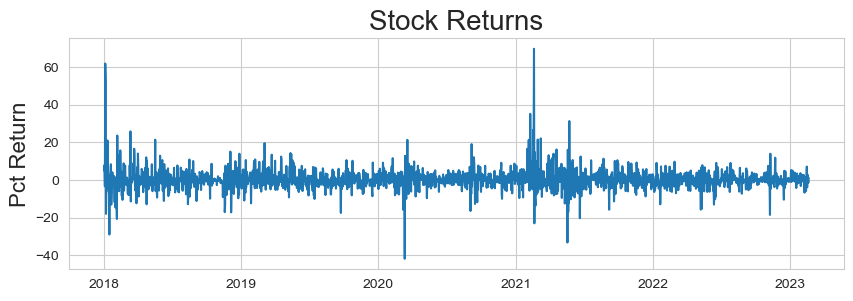

In [72]:
plt.figure(figsize=(10,3))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('Stock Returns', fontsize=20)

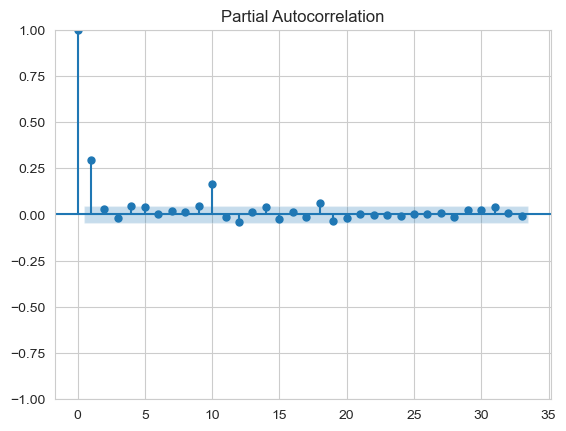

In [73]:
plot_pacf(returns**2)
plt.show()

In [74]:
from arch import arch_model

##### Change the number of years defends on how many years data has been used ####################
#number of year data * Working days of a year #############

trainsize = 5*365

data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

T = len(nvda_log)

results = {}

for p in range(1, 5):
    
    for q in range(1, 5):
        
        print(f'{p} | {q}')

        result = []

        for s, t in enumerate(range(trainsize, T-1)):

            train_set = data.iloc[s:t]

            test_set = data.iloc[t+1]

            model = arch_model(y=train_set, p=p, q=q).fit(disp='off')

            forecast = model.forecast(horizon=1)

            mu = forecast.mean.iloc[-1, 0]

            var = forecast.variance.iloc[-1, 0]

            result.append([(test_set-mu)**2, var])

        df = pd.DataFrame(result, columns=['y_true', 'y_pred'])

        results[(p, q)] = np.sqrt(mean_squared_error(df.y_true, df.y_pred))

1 | 1
1 | 2
1 | 3
1 | 4
2 | 1
2 | 2
2 | 3
2 | 4
3 | 1
3 | 2
3 | 3
3 | 4
4 | 1
4 | 2
4 | 3
4 | 4


In [75]:
pd.DataFrame(results, index=pd.Series(0)).unstack().idxmin()

(3, 4, 0)

# Put  'p' and 'q' value below box

In [76]:
data = nvda_log.clip(lower=nvda_log.quantile(.05),
                     upper=nvda_log.quantile(.95))

best_model = arch_model(y=data, p=3, q=4).fit(update_freq=5, disp='off')

print(best_model.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3468.84
Distribution:                  Normal   AIC:                          -6919.68
Method:            Maximum Likelihood   BIC:                          -6869.85
                                        No. Observations:                 1876
Date:                Wed, Feb 22 2023   Df Residuals:                     1875
Time:                        20:25:04   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.5026e-03  7.988e-04      1.881  5.997e-02 

# Again put 'p' and 'q' value from above model

In [79]:
train = returns
model = arch_model(train, p=3, q=4)
model_fit = model.fit(disp='off')

In [80]:
pred = model_fit.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

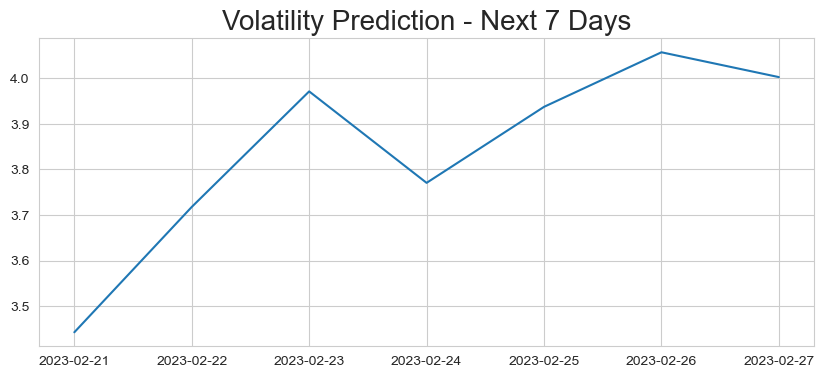

In [81]:
plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)